# Aula 12 - Background Segmentation

Referências: 
    1. Szeilisk - Cap 4
    1. Artigo Kim et a. - Real-time foreground–background segmentation using codebook model


In [1]:
%reset -f
%matplotlib inline
# from tqdm import tqdm


#!pip install opencv-python

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

print(cv.__version__)

3.4.2


___
## Projeto 2-2: Contagem de Pessoas

**Motivação**: http://www.cvg.reading.ac.uk/PETS2009/a.html#s1

Objetivo: Vocês devem tentar realizar a contagem de pessoas no dataset S1.L1 utilizando o modelo de codebook. As imagens foram distribuídas via pendrive.

Requisitos:
  * Tem que usar o modelo de codebook do artigo.
  * A partir da separação do foreground, vocês podem utilizar qualquer método para realizar a contagem, incluindo Clustering ou Machine Learning.
  * O Repositório no Git deve conter além do código fonte, os dados do codebook treinado salvo com Pickle e um relatório do projeto.
  * O relatório deve conter a metodologia utilizada (incluindo treinamento) e comentário sobre os resultados obtidos.

### Entrega: 03/Out 23:59 via GitHub.

### Rubrica do Projeto:

    I. Não entregou ou entregou apenas um rascunho.
    D. Implementou parcialmente o artigo ou não realizou a contagem.
    C. Implementou a sessão 2 do artigo e realizou uma contagem de forma simples.
    B. Cumpriu a rubrica C com a implementação completa do codebook.
    A. Além de cumprir a rubrica B, realiza a contagem com uma técnica elaborada.
    
    -1 Conceito se o relatório estiver ausente ou insatisfatório.

In [101]:
import pickle
import time
import cv2 as cv
import numpy as np
print(cv.__version__)
from tqdm import tqdm
import random

images = 10
epsilon = 12
alpha = 0.4    # 0.4 - 0.7
beta = 1.1     # 1.1 - 1.5
rows, cols = 576, 768



time_list = ["13-06", "13-19", "13-32", "13-38"]

# i1 = [34, 35, 42, 55, 72, 79, 86, 135, 156, 205, 254, 282, 317, 359, 408]
# i2 = [1, 51, 86, 223, 447]
# i3 = [1, 178, 367, 444]
# i4 = [46, 53, 60, 74, 88, 95, 102, 109, 116, 144, 151, 186, 235, 291, 354, 452]
# image_list.append(i1)
# image_list.append(i2)
# image_list.append(i3)
# image_list.append(i4)
# print(image_list)

def create_codebook_matrix(rows, cols):
    matrix = []
    for i in range(rows):
        matrix.append([])
        for j in range(cols):
            matrix[i].append([])
    return matrix

def create_random_images_list():
    matrix = []
    for j in range(4):
        matrix.append([])
    for i in range(10):
        image_number = random.randint(0, 446)
        image_time = random.randint(0, 4) - 1
        matrix[image_time].append(image_number)
    return matrix

def create_codeword(R, G, B, i_min, i_max, f, _lambda, p, q):
    return [R, G, B, i_min, i_max, f, _lambda, p, q]

def calculate_brightness(R, G, B):
    return ((R ** 2) + (G ** 2) + (B ** 2)) ** 0.5

def calculate_color_dist(x, v):
    xt2 = (x[0] ** 2) + (x[1] ** 2) + (x[2] ** 2)
    vi2 = (v[0] ** 2) + (v[1] ** 2) + (v[2] ** 2)
    dot_product2 = ((v[0] * x[0]) + (v[1] * x[1]) + (v[2] * x[2])) ** 2
    if(vi2 == 0):
        return abs(xt2) ** 0.5
    p2 = dot_product2 / (vi2)
    return abs(xt2 - p2) ** 0.5

def calculate_high_low_brightness(alpha, beta, i_max, i_min):
    i_low = alpha * i_max
    i_high = min(beta* i_max, (i_min/alpha))
    return i_low, i_high

def brightness(I, i_low, i_high):
    return (i_low <= I <= i_high)

def construct_codebook(pixel, t, codebook):
    # pixel = pixel.astype(float)
    R = pixel[0]
    G = pixel[1]
    B = pixel[2]
    I = calculate_brightness(R, G, B)
    i_max = I
    i_min = I
    matched = False
    for codeword in codebook:
        color_dist = calculate_color_dist([R, G, B], [codeword[0], codeword[1], codeword[2]])
        i_low, i_high = calculate_high_low_brightness(alpha, beta, codeword[3], codeword[4])
        b = brightness(I, i_low, i_high) 
        if((color_dist <= epsilon) and b):
            new_R = ((codeword[5] * codeword[0]) + R)/ (codeword[5] + 1)
            new_G = ((codeword[5] * codeword[1]) + G)/ (codeword[5] + 1)
            new_B = ((codeword[5] * codeword[2]) + B)/ (codeword[5] + 1)
            codeword[0] = new_R
            codeword[1] = new_G
            codeword[2] = new_B
            codeword[4] = max(I, codeword[4])
            codeword[3] = min(I, codeword[3])
            codeword[5] +=1
            codeword[6] = max(codeword[6], t - codeword[8])
            codeword[8] = t
            matched = True
            break
    if not matched:
        new_codeword = create_codeword(R, G, B, I, I, 1, t - 1, t, t)
        codebook.append(new_codeword)
    return codebook

def adjust_lambda(matrix_codebooks, number_of_images = 40):
    for i in range(len(matrix_codebooks)):
        for j in range(len(matrix_codebooks[i])):
            for codeword in matrix_codebooks[i][j]:
                codeword[6] = max(codeword[6], (number_of_images - codeword[8] + codeword[7] - 1))
    return matrix_codebooks

def clean_file(filepath):
    pickle_in = open(filepath,"rb")
    matrix_codebooks = pickle.load(pickle_in)

    new_matrix = create_codebook_matrix(rows, cols)

    for i in (range(len(matrix_codebooks))):
        for j in range(len(matrix_codebooks[i])):
            for codeword in matrix_codebooks[i][j]:
                _lambda = codeword[6]
                if(_lambda >= images/2):
                    new_matrix[i][j].append(codeword)

    pickle_out = open("codebook10_clean.pickle","wb")
    pickle.dump(new_matrix, pickle_out)
    pickle_out.close()


3.4.2


In [102]:

start = time.time()

print("Training...")
image_list = create_random_images_list()
matrix_codebooks = create_codebook_matrix(rows, cols)
image_index = 1
for k in (range(len(time_list))):
    for l in (range(len(image_list[k]))):
        print("-" * 16)
        print(f"IMAGE: {image_index}")
        string_image = '0' * (8-len(str(image_list[k][l]))) + str(image_list[k][l])
        path_image = "./Crowd_PETS09/S0/Background/View_001/Time_{0}/{1}.jpg".format(time_list[k], string_image)
        image = cv.imread(path_image)
        image = image.astype(float)
        st = time.time()
        for i in range(rows):
            for j in range(cols):
                pixel = image[i][j]
                actual_codebook = matrix_codebooks[i][j]
                new_codebook = construct_codebook(pixel, image_index, actual_codebook)
                matrix_codebooks[i][j] = new_codebook
        en = time.time()
        print(f"Time: {en-st}")
        image_index+=1


matrix_codebooks = adjust_lambda(matrix_codebooks, 40)
end = time.time()
print("TIME: {}".format(end-start))



Training...
----------------
IMAGE: 1
Time: 1.5166232585906982
----------------
IMAGE: 2
Time: 4.84248685836792
----------------
IMAGE: 3
Time: 5.08678674697876
----------------
IMAGE: 4
Time: 7.261631011962891
----------------
IMAGE: 5
Time: 6.923756122589111
----------------
IMAGE: 6
Time: 8.187435865402222
----------------
IMAGE: 7
Time: 8.357270002365112
----------------
IMAGE: 8
Time: 8.217264890670776
----------------
IMAGE: 9
Time: 8.134973049163818
----------------
IMAGE: 10
Time: 8.4204580783844
TIME: 68.82210397720337


In [103]:
print("Writing file...")
pickle_out = open("codebook10.pickle","wb")
pickle.dump(matrix_codebooks, pickle_out)
pickle_out.close()

Writing file...


In [104]:
clean_file("codebook10.pickle")

In [113]:
import pickle
from tqdm import tqdm
import cv2 as cv
import numpy as np
import pickle
import time


epsilon = 150
alpha = 0.6    # 0.4 - 0.7
beta = 1.5     # 1.1 - 1.5
rows, cols = 576, 768

pickle_in = open("codebook10_clean.pickle","rb")
matrix_codebooks = pickle.load(pickle_in)

def test(pixel, t, i, j, matrix_codebooks):
    R = pixel[0]
    G = pixel[1]
    B = pixel[2]
    I = calcBrightness(R, G, B)
    i_max = I
    i_min = I
    index = 0
    codebook = matrix_codebooks[i][j]
    matched = False
    for codeword in codebook:
        color_dist = calculate_color_dist([R, G, B], [codeword[0], codeword[1], codeword[2]])
        i_low, i_high = calculate_high_low_brightness(alpha, beta, codeword[3], codeword[4])
        b = brightness(I, i_low, i_high) 
        if((color_dist <= epsilon) and b):
            matched = True
            result = [0,0,0]
            break
    if(matched ==  False):
        result = [255,255,255]
        
    return result


def load_image(image_number):
    string_image = '0' * (8-len(str(image_number))) + str(image_number)
#     string_image =  'frame_'+ '0' * (4-len(str(image_number))) + str(image_number)
#     path_image = './Crowd_PETS09-2/S1/L1/Time_13-57/View_001/{}.jpg'.format(string_image)
#     path_image = './Crowd_PETS09-1/S0/City_Center/Time_12-34/View_001/{}.jpg'.format(string_image)
    path_image = './Crowd_PETS09/S0/Background/View_001/Time_13-19/{}.jpg'.format(string_image)
    print(path_image)
    
    image = cv.imread(path_image)
    image = image.astype(float)
    return image

def subtract(image_number):
    start = time.time()
    image_number = 150
    image = load_image(image_number)
    for i in range(rows):
        for j in range(cols):
            actual = image[i][j]
            image[i][j] = test(actual, image_number, i, j, matrix_codebooks)

    plt.imshow(np.uint8(image))
    plt.show()

                # matrix_codebooks = construct_codebook(actual, n, i, j, matrix_codebooks)

    end = time.time()
    print("TIME: {}".format(end-start))


./Crowd_PETS09/S0/Background/View_001/Time_13-19/00000150.jpg


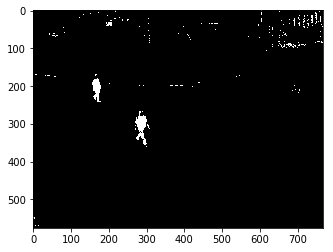

TIME: 4.134420871734619


In [114]:
subtract(150)

In [107]:
# for i in range(len(matrix_codebooks)):
#     for j in range(len(matrix_codebooks[i])):
#         print(len(matrix_codebooks[i][j]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


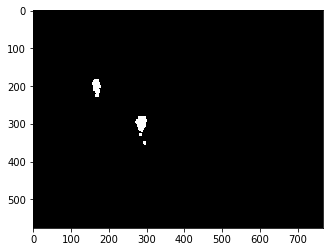

In [108]:
kernel = np.ones((7,7),np.uint8)
erosion = cv.erode(image,kernel,iterations = 1)
dilation = cv.dilate(erosion,kernel,iterations = 1)
# dilation = cv.dilate(dilation,kernel,iterations = 1)

plt.imshow(dilation)

In [112]:
params = cv.SimpleBlobDetector_Params()

params.filterByInertia = False
params.filterByConvexity = False
# params.filterByColor = (0,0,0)

detector = cv.SimpleBlobDetector_create(params) 
# Detect blobs.
keypoints = detector.detect(np.uint8(dilation))
im_with_keypoints = cv.drawKeypoints(np.uint8(image), keypoints, np.array([]), (0,255,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow((im_with_keypoints))
print(len(keypoints))

0
